In [1]:
import os

os.environ["PYSYN_CDBS"] = "/home/ruizhew/POSEIDON/inputs/stellar_grids/"
os.environ["POSEIDON_input_data"] = "/home/ruizhew/POSEIDON/inputs/"

In [2]:
from __future__ import absolute_import, unicode_literals, print_function
from POSEIDON.high_res import (
    fast_filter,
    loglikelihood_sysrem,
    get_rot_kernel,
    fit_uncertainties,
)
import math, os
import numpy as np
import pickle
import pickle
from scipy import constants
from numba import jit
from astropy.io import fits
from scipy import interpolate
from POSEIDON.core import (
    create_star,
    create_planet,
    define_model,
    make_atmosphere,
    read_opacities,
    wl_grid_constant_R,
    wl_grid_line_by_line,
    compute_spectrum,
)
from POSEIDON.constants import R_Sun
from POSEIDON.visuals import plot_stellar_flux
from POSEIDON.constants import R_J, M_J
import numpy as np
from spectres import spectres
from tqdm import tqdm
from multiprocessing import Pool
import time

R_s = 1.458 * R_Sun  # Stellar radius (m)
T_s = 6776  # Stellar effective temperature (K)
Met_s = 0.13  # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.24  # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s, stellar_grid="phoenix")

F_s = star["F_star"]
wl_s = star["wl_star"]
R_s = star["R_s"]


# ***** Define planet properties *****#

planet_name = "WASP-121b"  # Planet name used for plots, output files etc.

R_p = 1.753 * R_J  # Planetary radius (m)
M_p = 1.157 * M_J  # Mass of planet (kg)
g_p = 10 ** (2.97 - 2)  # Gravitational field of planet (m/s^2)
T_eq = 2450  # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, mass=M_p, gravity=g_p, T_eq=T_eq)

# If distance not specified, use fiducial value
if planet["system_distance"] is None:
    planet["system_distance"] = 1  # This value only used for flux ratios, so it cancels
d = planet["system_distance"]

# ***** Define model *****#

model_name = "High-res retrieval"  # Model name used for plots, output files etc.

bulk_species = ["H2", "He"]  # H2 + He comprises the bulk atmosphere
param_species = ["Fe"]  # H2O, CO as in Brogi & Line

# Create the model object
model = define_model(model_name, bulk_species, param_species, PT_profile="Madhu")

# Check the free parameters defining this model
print("Free parameters: " + str(model["param_names"]))


# ***** Wavelength grid *****#

wl_min = 0.37  # Minimum wavelength (um)
wl_max = 0.51  # Maximum wavelength (um)
R = 200000  # Spectral resolution of grid

# wl = wl_grid_line_by_line(wl_min, wl_max)
wl = wl_grid_constant_R(wl_min, wl_max, R)

# ***** Read opacity data *****#

opacity_treatment = "opacity_sampling"

# Define fine temperature grid (K)
T_fine_min = 2000  # 400 K lower limit suffices for a typical hot Jupiter
T_fine_max = 4500  # 2000 K upper limit suffices for a typical hot Jupiter
T_fine_step = 20  # 20 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6.0  # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2.5  # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2  # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(
    log_P_fine_min, (log_P_fine_max + log_P_fine_step), log_P_fine_step
)

# Now we can pre-interpolate the sampled opacities (may take up to a minute)
opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

# Specify the pressure grid of the atmosphere
P_min = 1e-12  # 0.1 ubar
P_max = 100  # 100 bar
N_layers = 100  # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 1e-5  # Reference pressure (bar)
R_p_ref = R_p  # Radius at reference pressure


params = (-6.0, 2, 1, -2.5, -1.5, 1, 3000)
log_Fe, a1, a2, log_P1, log_P2, log_P3, T_ref = params

# Provide a specific set of model parameters for the atmosphere
PT_params = np.array(
    [a1, a2, log_P1, log_P2, log_P3, T_ref]
)  # a1, a2, log_P1, log_P2, log_P3, T_deep
log_X_params = np.array([[log_Fe]])

atmosphere = make_atmosphere(planet, model, P, P_ref, R_p_ref, PT_params, log_X_params)

# Generate planet surface flux
spectrum = compute_spectrum(
    planet, star, model, atmosphere, opac, wl, spectrum_type="transmission"
)

Free parameters: ['R_p_ref' 'a1' 'a2' 'log_P1' 'log_P2' 'log_P3' 'T_ref' 'log_Fe']
Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
Fe done
Opacity pre-interpolation complete.


In [3]:
model_name = "High-res retrieval"  # Model name used for plots, output files etc.

bulk_species = ["H2", "He"]  # H2 + He comprises the bulk atmosphere
param_species = []  # H2O, CO as in Brogi & Line

# Create the model object
model = define_model(model_name, bulk_species, param_species, PT_profile="Madhu")

# Check the free parameters defining this model
print("Free parameters: " + str(model["param_names"]))

params = (2, 1, -2.5, -1.5, 1, 3000)
a1, a2, log_P1, log_P2, log_P3, T_ref = params

# Provide a specific set of model parameters for the atmosphere
PT_params = np.array(
    [a1, a2, log_P1, log_P2, log_P3, T_ref]
)  # a1, a2, log_P1, log_P2, log_P3, T_deep

atmosphere = make_atmosphere(planet, model, P, P_ref, R_p_ref, PT_params, log_X_params)

# Generate planet surface flux
continuum = compute_spectrum(
    planet, star, model, atmosphere, opac, wl, spectrum_type="transmission"
)

Free parameters: ['R_p_ref' 'a1' 'a2' 'log_P1' 'log_P2' 'log_P3' 'T_ref']


In [15]:
from POSEIDON.utility import read_high_res_data
from POSEIDON.high_res import fit_uncertainties
import numpy as np
import matplotlib.pyplot as plt

output_data_dir = "./data/WASP-121b-injection/"
# These data are both in the rest frame of the star. The blue data are aligned with cross-correlation to stellar lines, and the red data are aligned via cross-correlation with a telluric template (however, in the latter case we also shift/interpolate according to the barycentric and systemic velocities to compensate)
al = np.load("./data/WASP-121b/aligned_C_arrays.npz")
# And the aligned data are stored as:
C, Ce = al["aligned/blue/C"], al["aligned/blue/Ce"]  # etc, replace blue with redl/redu
# And just to be extra confusing, I've already stripped out the 70,71,72 frames. (But not the outer orders)
wl_grid, _ = pickle.load(open("./data/WASP-121b/data_raw.pic", "rb"))
phi = pickle.load(open(output_data_dir + "phi.pic", "rb"))
transit_weight = pickle.load(open(output_data_dir + "transit_weight.pic", "rb"))

In [9]:
from scipy.ndimage import gaussian_filter1d, median_filter

W_conv = 5
a = 1
b = 1
model = (spectrum - continuum) * a + continuum
# spectrum_broadened = gaussian_filter1d(model, W_conv)
spectrum_broadened = model

In [13]:
V_sys = -10
K_p = -200
d_phi = 0
RV_p = V_sys + K_p * np.sin(
    2 * np.pi * (phi + d_phi)
)  # V_sys is an additive term around zero
dl_p = RV_p * 1e3 / constants.c  # delta lambda, for shifting
cs_p = interpolate.splrep(wl, spectrum_broadened, s=0.0)

In [16]:
N_order, N_phi, N_wl = C.shape


def test_loop_np():
    models_shifted = np.zeros(C.shape)  # "shifted" model spectra array at each phase
    for i in range(N_order):
        for j in range(N_phi):
            wl_shifted_p = wl_grid[i] * (1.0 - dl_p[j])
            Fp = np.interp(wl_shifted_p, wl, spectrum_broadened)
            models_shifted[i][j] = ((1 - transit_weight[j])) / np.max(
                1 - transit_weight
            ) * (-Fp) + 1
    return models_shifted

In [17]:
models_shifted = test_loop_np()

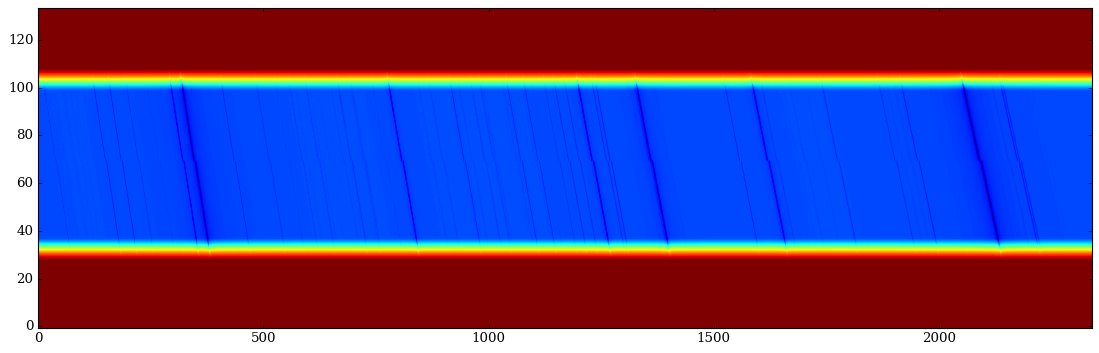

In [18]:
output_path = "./CC_output/WASP-121b/"
plt.figure(figsize=(17, 5))
plt.imshow(models_shifted[15], aspect="auto", origin="lower")
plt.savefig(output_path + "shifted_model.pdf", fmt="pdf")

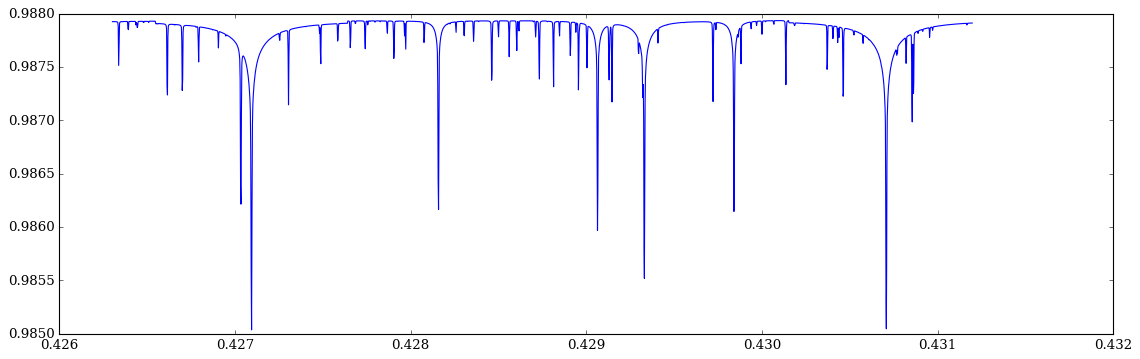

In [19]:
plt.figure(figsize=(17, 5))
plt.plot(wl_grid[15], models_shifted[15][100])
plt.ticklabel_format(useOffset=False)

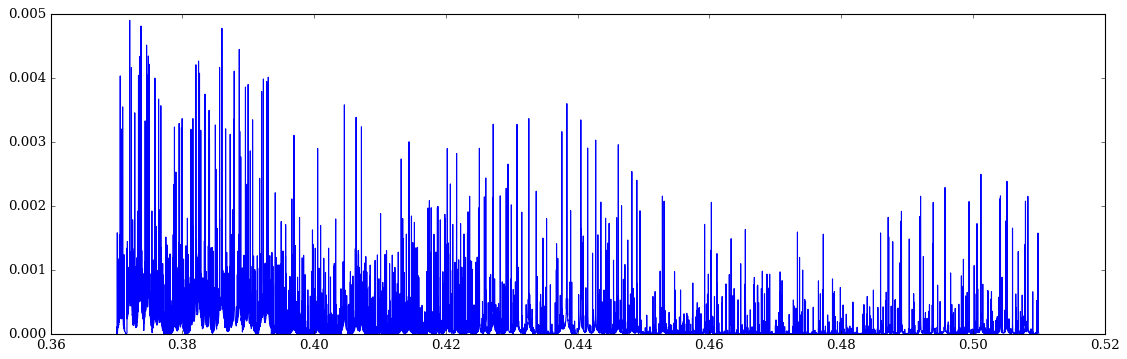

In [20]:
plt.figure(figsize=(17, 5))
plt.plot(wl, spectrum - continuum)
plt.ticklabel_format(useOffset=False)

In [23]:
data_injected = models_shifted * C

In [25]:
C_norm = np.zeros(data_injected.shape)
for k in range(N_order):
    order = data_injected[k]

    middle = np.median(order, axis=0)
    middle[middle == 0] = np.mean(middle)
    order_norm = order / middle

    C_norm[k] = order_norm

In [26]:
from scipy.ndimage import gaussian_filter1d, median_filter

for det in range(N_order):
    for phi in range(N_phi):
        C_norm[det][phi] = median_filter(C_norm[det][phi], size=501)

for det in range(N_order):
    for phi in range(N_phi):
        C_norm[det][phi] = gaussian_filter1d(C_norm[det][phi], sigma=100)

In [27]:
data = data_injected / C_norm
data[data < 0] = 0

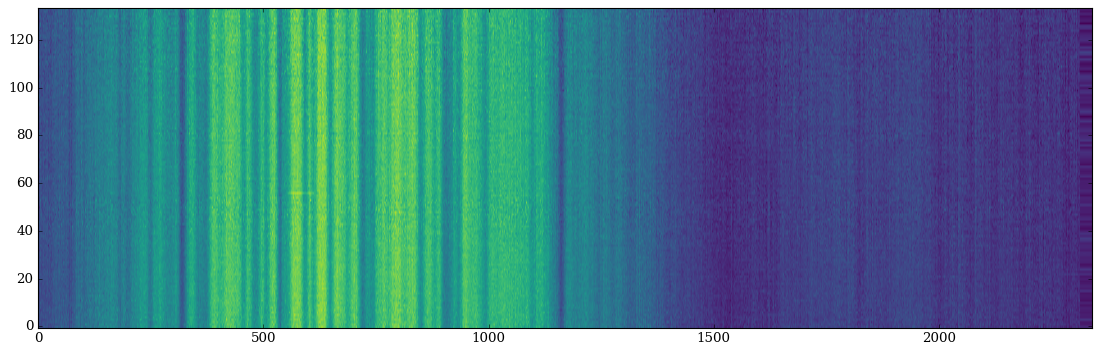

In [28]:
plt.figure(figsize=(17, 5))
plt.imshow(data[6], aspect="auto", origin="lower", cmap="viridis")
plt.savefig(output_path + "blaze_corrected.pdf", fmt="pdf")

In [29]:
uncertainties = fit_uncertainties(data, NPC=5)

0.3856228981329187 232.61680678405358
0.3713202710610186 256.14748994697993
0.3612277921380692 260.3365919594888
0.38564343042286975 255.0582717801529
0.3573100199525305 263.50609333408835
0.38828496814029567 253.44590987483735
0.39075346218926177 255.4758264599353
0.39369605487330345 250.0330012136872
0.368786684074616 256.7234982565988
0.3506328336411265 261.60176491891616
0.3510469896344423 260.0444536150844
0.35350673494415075 256.1491215212884
0.3364826337941852 263.46671726655984
0.3118957882163682 270.9296798040393
0.3246370912733867 262.97118483152593
0.3227870231528999 262.81154980977055
0.3271154038973578 259.99470781051184
0.29656635983311574 276.25952959001074
0.28984577892047536 282.33197488160044
0.29213059580265477 277.4914369319283
0.2947392519910714 274.975508478715
0.297348201713632 272.15457636946826
0.2844528366106158 281.0690105719261
0.2968368521908527 272.9091887209416
0.29891715451558715 266.7966932012653
0.3096904020673068 259.2614039941277
0.3182169601211713 2

In [30]:
a = uncertainties.copy()

In [31]:
mask = data == 0
a[mask] = 1e7
uncertainties = a

In [32]:
from POSEIDON.high_res import fast_filter

for i in range(len(data)):
    order = data[i]

    median = np.median(order, axis=0)
    median[median == 0] = np.mean(median)
    order_norm = order / median

    uncertainty = uncertainties[i]

    uncertainty_norm = uncertainty / median

    uncertainties[i] = uncertainty_norm
    data[i] = order_norm

residuals, Us = fast_filter(data, uncertainties, N_iter=15)

In [33]:
output_data_dir = "data/WASP-121b-injection/"
pickle.dump(
    uncertainties,
    open(output_data_dir + "/uncertainties.pic", "wb"),
)
pickle.dump(
    [wl_grid, data],
    open(output_data_dir + "/data_raw.pic", "wb"),
)

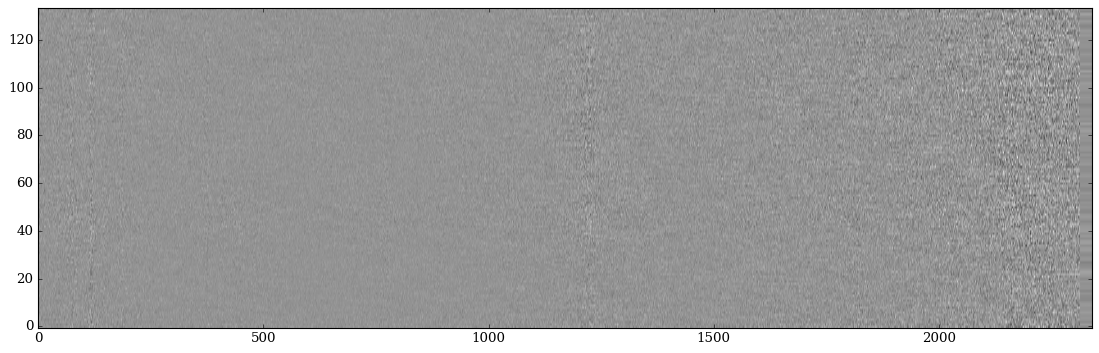

In [34]:
plt.figure(figsize=(17, 5))
plt.imshow(residuals[10], aspect="auto", origin="lower", cmap="gray")
plt.savefig(output_path + "filtered.pdf", fmt="pdf")

In [35]:
N_order, N_phi, N_wl = C.shape
Bs = np.zeros((N_order, N_phi, N_phi))

for j in range(N_order):
    U = Us[j]
    L = np.diag(1 / np.mean(uncertainties[j], axis=-1))
    B = U @ np.linalg.pinv(L @ U) @ L
    Bs[j] = B

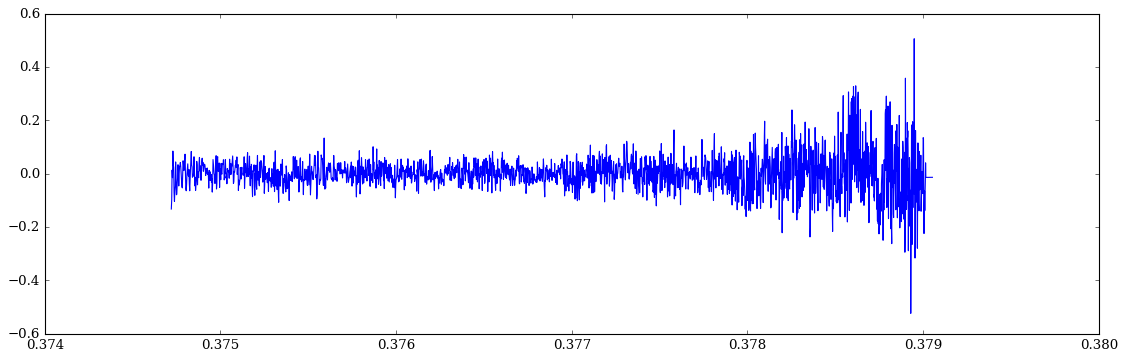

In [36]:
plt.figure(figsize=(17, 5))
plt.plot(wl_grid[0], residuals[15][100])
plt.ticklabel_format(useOffset=False)

In [37]:
j = 15
models_shifted = models_shifted[j]

In [38]:
models_shifted = (models_shifted.T / np.median(models_shifted, axis=1)).T
B = Bs[j]
model_filtered = models_shifted - B @ models_shifted

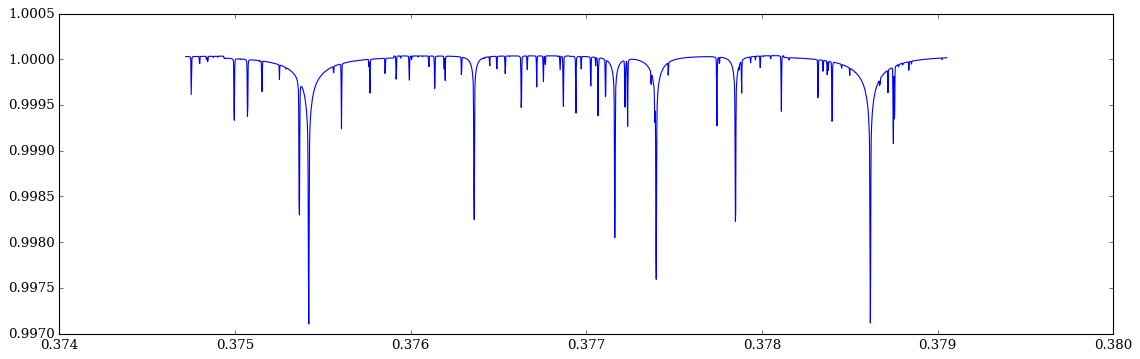

In [39]:
plt.figure(figsize=(17, 5))
plt.plot(wl_grid[0], models_shifted[100])
plt.ticklabel_format(useOffset=False)

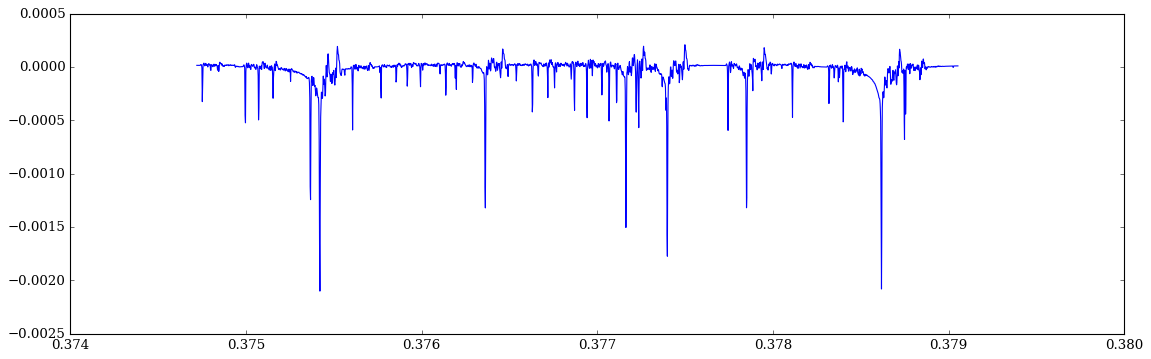

In [40]:
plt.figure(figsize=(17, 5))
plt.plot(wl_grid[0], model_filtered[100])
plt.ticklabel_format(useOffset=False)

In [41]:
pickle.dump([Bs, residuals], open(output_data_dir + "/fast_filter.pic", "wb"))